# To Do
1. Currently implementing Ubc and Vbc
2. After the above the linear solutions for: implicit viscocity, and pressure, can be implemented.
3. Visualisation
4. Implement cholensky matrices (more efficient)

In [822]:
import numpy as np
import scipy as sci

import matplotlib.pyplot as plt
import scipy.sparse as spa
import scipy.sparse.linalg as spala 

from types import SimpleNamespace

# Initial conditions 
const = SimpleNamespace() # Proposal const -> cst
par = SimpleNamespace()

const.Re = 1e2     # Reynolds number
const.dt = 1e-2    # time step
const.tf = 500e-2  # final time
const.lx = 10      # width of box
const.ly = 10      # height of box
const.nx = 4       # number of x-gridpoints
const.ny = 4       # number of y-gridpoints
const.nsteps = 10  # number of steps with graphic output

const.nt = np.ceil(const.tf/const.dt)
const.dt = const.tf/const.nt;

# Constuct grid
const.x, const.y = np.linspace(0, const.lx, const.nx+1), np.linspace(0, const.ly, const.ny+1)
const.hx, const.hy = const.lx/const.nx, const.ly/const.ny
[const.X,const.Y] = np.meshgrid(const.y, const.x);

# IC's
U = np.zeros((const.nx-1, const.ny), dtype = float)
V = np.zeros((const.nx, const.ny-1), dtype = float)

# BC's
## North, East, South, West

uN = const.x*0 + 1
uE = ave(const.y, 'h')*0 
uS = const.x*0
uW = ave(const.y, 'h')*0

vN = ave(const.x, 'h')*0 
vW = const.y*0
vS = ave(const.x, 'h')*0
vE = const.y*0

# Boundary matrices
## WIP see lower cell
## Implement boundary matrices Ubc and Bvc

# Operator matrices on P, U, V, Q respectively
Lp = spa.kron(spa.eye(const.ny), laplace_m(const.nx, const.hx, 'Neumann')) +\
     spa.kron(laplace_m(const.ny, const.hy, 'Neumann'), spa.eye(const.nx))
Lu = spa.eye((const.nx-1)*const.ny) + \
     (const.dt/const.Re)*(spa.kron(spa.eye(const.ny), laplace_m(const.nx-1, const.hx, 'Dirichelt_on')))+\
     spa.kron(laplace_m(const.ny, const.hy, 'Dirichelt_between'), spa.eye(const.nx-1))
Lv = spa.eye((const.ny-1)*const.nx) + \
     (const.dt/const.Re)*(spa.kron(spa.eye(const.ny-1), laplace_m(const.nx, const.hx, 'Dirichelt_between')))+\
     spa.kron(laplace_m(const.ny-1, const.hy, 'Dirichelt_on'), spa.eye(const.nx))
Lq = spa.kron(spa.eye(const.ny-1), laplace_m(const.nx-1, const.hx, 'Dirichlet_on')) +\
     spa.kron(laplace_m(const.ny-1, const.hy, 'Dirichlet_on'), spa.eye(const.nx-1))
       
# Implement pre solution matrices
## WIP
## Need to figure out how to use cholensky with sparse matrices
## possibly scikit offers it. For now this is not implemented


loop = True
counter = 0

while loop:
    counter += 1
    
    # Non linear terms
    Ue = np.vstack((uS, np.vstack((uW, U, uE)).T, uN)).T
    Ve = np.vstack((vW, np.vstack((vS, V.T, vN)).T, vE))

    # If x and y are made 2D
    ## Ue = np.concatenate((uS, np.concatenate((uW, U.T, uE), axis = 0).T, uN), axis = 0)
    ## Ve = np.concatenate((vW, np.concatenate((vS.T, V, vN.T), axis = 1), vE), axis = 0)
    
    # Average and difference matrices
    Ua = ave(Ue, 'v')
    Ud = np.diff(Ue, n=1, axis=1)/2
    Va = ave(Ve, 'h')
    Vd = np.diff(Ve, n=1, axis=0)/2
    
    # Derivative matrices UV_x and UV_y
    UVx = np.diff((Ua*Va - gamma(const, U, V)*np.abs(Ua)*Vd), axis=0)/const.hx
    UVy = np.diff((Ua*Va - gamma(const, U, V)*Ud*np.abs(Va)), axis=1)/const.hy
    
    # Average and difference matrices
    Ua = ave(Ue[:,1:-1], 'h')
    Ud = np.diff(Ue[:,1:-1], n=1, axis=0)/2
    Va = ave(Ve[1:-1,:], 'v')
    Vd = np.diff(Ve[1:-1,:], n=1, axis=1)/2
    
    # Derivative matrices U^2_x and U^2_y
    U2x = np.diff((Ua**2 - gamma(const, U, V)*np.abs(Ua)*Ud), axis=0)/const.hx
    V2y = np.diff((Ua**2 - gamma(const, U, V)*np.abs(Va)*Vd), axis=1)/const.hy
    
    # Change in velocity applied
    U = U - const.dt*(UVy[1:-1,:] + U2x)
    V = V - const.dt*(UVx[:,1:-1] + V2y)    
    
    # Implicit viscocity 
    # WIP see lower cell
    
    # Pressure correction    
    ## WIP
    
    # Visualization
    ## WIP
    
    if counter == 10:
        loop = False


In [824]:
# Ubc and Vbc WIP
Ubc = const.dt/Re


In [ ]:
Ubc = dt/Re*([2*uS(2:end-1)’ zeros(nx-1,ny-2) 2*uN(2:end-1)’]/hx^2+...
[uW;zeros(nx-3,ny);uE]/hy^2);
Vbc = dt/Re*([vS’ zeros(nx,ny-3) vN’]/hx^2+...
[2*vW(2:end-1);zeros(nx-2,ny-1);2*vE(2:end-1)]/hy^2);

In [820]:
# Viscocity WIP
u = spala.spsolve(Lu, np.reshape(U + Ub,(-1,1)))
U = np.reshape(U,(const.nx-1, const.ny))
U

NameError: name 'Ub' is not defined

In [775]:
from sys import getsizeof
getsizeof(Lp)

56

In [765]:
def ave(A, axis):
    """
    axis = h(orizontal), v(ertical) 
    """
    if axis == 'v':
        A = np.transpose(A)
        
    average = (A[0:-1] + A[1:])/2
    
    if axis == 'v':
        average = np.transpose(average)
    
    return average

def gamma(const, U, V):
    """
    Returns gamma factor
    """
    return np.min((1.2*const.dt*np.max((np.max((np.abs(U)/const.hx)), np.max((np.abs(V)/const.hy)))), 1))

def laplace_m(n, h, bc):
    diag_len = n 
    Lm = 2*np.ones(diag_len)  # Create diagonal values 
    Lu = np.diag(-1*np.ones(diag_len-1), k=1) # Up offdiagonal value 
    Ld = np.diag(-1*np.ones(diag_len-1), k=-1)# Down offdiagonal value 
   
    if bc == 'Neumann':
        Lm[[0,-1]] = 1 
        
    if bc == 'Dirichelet_on':
        Lm[[0,-1]] = 2 
    
    if bc == 'Dirichelet_between':
        Lm[[0,-1]] = 3 
    
    Lm=np.diag(Lm, k=0)
    
    L = (Lu + Lm + Ld)/h**2
    
    return L


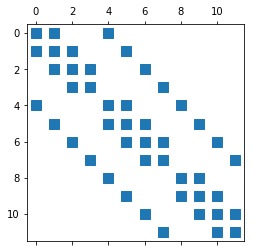

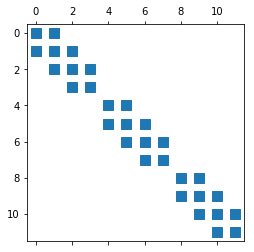

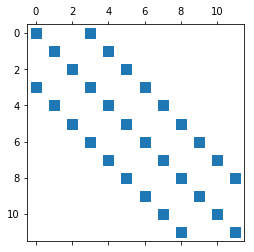

In [786]:
# This is usefull to get an idea of how the matrices are becoming what they are.
# Use nx and ny to be 4 to see the similarities
plt.spy(Lv)
plt.show()
plt.spy(sparse.kron(sparse.eye(3), laplace_m(4, 1, 'Neumann')))
plt.show()
plt.spy(sparse.kron(laplace_m(4, 1, 'Neumann'), sparse.eye(3)))
plt.show()